# Bayesian Cosmology

We will attempt to explore a simple cosmological model for the evolution of the universe using some real-world supernova data. This topic is very deep and you can spend an entire degree in physics learning what that goes into cosmology, but we will try and highlight some of the basics and provide links for further reading.  

The cosmology we are going to investigate is a *radiation free* universe, which only has two parameters: 
* $\Omega_{\Lambda}$, also known as dark energy or the [cosmological constant](https://en.wikipedia.org/wiki/Cosmological_constant);
*  $\Omega_M$, also known as [dark matter](https://en.wikipedia.org/wiki/Dark_matter).

We will also assume a prior that the [universe is flat](https://en.wikipedia.org/wiki/Shape_of_the_universe), which essentially just forces the additional constraint at the end that $\Omega_{\Lambda} + \Omega_M = 1$.

For those further interested in the physics, this is the starting point for the [Lambda-CDM model](https://en.wikipedia.org/wiki/Lambda-CDM_model). However, we are just going to assume the physicists know what they are doing, and try calculate posterior distributions over the 2 model parameters using bayesian inference.


# Friedmann Equations


The [Friedmann Equations](https://en.wikipedia.org/wiki/Friedmann_equations) are a set of equations which govern how the expansion of the universe evolves. The Friedmann equation for a flat lambda universe, and therefore of focus to us is
$$
\frac{H^2}{H_0^2} = \Omega_M (1 + z)^3 + (1 - \Omega_{\Lambda} - \Omega_M) (1 + z)^2 + \Omega_{\Lambda}.
$$
$H$ is known as the [Hubble factor](https://en.wikipedia.org/wiki/Hubble%27s_law) and quantifies how quickly the universe is expanding. $z$ is the [redshift](), which states how much light gets distorted as it travels through the universe to reach us from far away stars. $H_0$ is the [Hubble factor today](https://en.wikipedia.org/wiki/Hubble%27s_law#21st_century_measurements), which we will take as a known value $H_0 = 70 \text{km} \text{ s}^{-1} \text{ Mpc}^{-1}$.

Using the Friedmann equation and a bit of nobel-prize winning physics, we can relate the apparent brightness of [supernova]() explosions to their measured redshift. See [Perlmutter97](https://arxiv.org/pdf/astro-ph/9608192.pdf), [Astier05](https://www.aanda.org/articles/aa/pdf/2006/07/aa4185-05.pdf). 
$$
m(z) = 5 \log_{10} (d_L (z ; \Omega_{\Lambda}, \Omega_M) / 10 \text{pc} )
$$

Where the cosmological parametrisation lies in the luminosity distance, $d_L$, given by 
$$
d_L (z ; \Omega_{\Lambda}, \Omega_M) = \frac{c(1+z)}{H_0 \sqrt{|\kappa|}} \mathcal{S} \left ( \sqrt{|\kappa|} \int_0^z [(1+z')^2(1+\Omega_M z') - z'(2+z')\Omega_{\Lambda}]^{-\frac{1}{2}} dz' \right).
$$
Here, $c = 299,792 \text{km/s}$ is the speed of light and
$$
\kappa = 
\begin{cases}
1, &\Omega_{\Lambda} + \Omega_M = 1 \\
1 - \Omega_{\Lambda} - \Omega_M, &\text{otherwise}
\end{cases}
$$
$$
\mathcal{S}(x) = 
\begin{cases}
\sin(x), &\Omega_{\Lambda} + \Omega_M > 1 \\
x, &\Omega_{\Lambda} + \Omega_M = 1\\
\sinh(x), &\Omega_{\Lambda} + \Omega_M < 1
\end{cases}
$$
Now these expressions looks very complicated at first glance, and they are. We dont fully understand them either. However, one of the skills that is important in quant finance is the ability to implement a model that you might not have time or expertise to fully understand. It is important to be able to abstract away the meaning behind equations and continue from there in a pragmatic workplace. 

The above expressions are really just some basic math functions, a piecewise function, and an integral. Implementing this in python shouldn't be too difficult. Take care to make sure all the units are correct and you dont forget to divide by $10\text{pc}$ in your luminosity distance.

# Likelihood Function

Now we have an expression for $m(z ; \Omega_{\Lambda}, \Omega_M)$ we use the supernova dataset from [Astier et al., 2005.](https://www.aanda.org/articles/aa/pdf/2006/07/aa4185-05.pdf) that we have provided in `supernova_data.csv` along with a likelihood function to run a Bayesian analysis. 

The idea is to assume a value for $(\Omega_{\Lambda}, \Omega_M)$ and then calculate the $\chi^2$ of the fit $m(z)$ with our data $D$. The larger the $\chi^2$, the worse the fit is and therefore the lower the likelihood. We can express this by treating the $\chi^2$ value as a boltzmann factor and say our likelihood is proportional to
$$
\mathcal{L}(\Omega_{\Lambda}, \Omega_M) = e^{-\chi^{2} (\Omega_{\Lambda}, \Omega_M)}
$$

The $\chi^2$ is simply the sum of all residuals
$$
\chi^2(\Omega_{\Lambda}, \Omega_M) = \sum_i \left( m_{\text{data}}(z) - m_{\text{model}}(z ; \Omega_{\Lambda}, \Omega_M) \right)^2
$$

Now you have all the maths required to run a 2-dimensional Bayesian inference on a simple cosmological model. You should be able to calculate and plot a posterior distribution which shows the most likely values for our universes dark matter and dark energy densities.

Something like this
[image]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import scipy

c = 299792 # speed of light (km/s)
H0 = 70 / 1000000 # hubble constant (km/s/pc)

In [3]:
def curvature(x, dt):
    if dt > 1:
        return math.sin(x)
    elif dt == 1:
        return x
    elif dt < 1:
        return math.sinh(x)


def integral_func(x, de, dm):
    return ((1 + x)**2 * (1 + x*dm) - x * (2 + x) * de)**(-0.5)


def scale_factor(z, de, dm):
    kappa = 1 - de - dm if de + dm != 1 else 1

    integrand = scipy.integrate.quad(integral_func, 0, z, args=(de, dm))[0]

    return curvature(integrand * np.sqrt(abs(kappa)), de + dm)


def luminosity_distance(z, de, dm):
    kappa = 1 - de - dm if de + dm != 1 else 1

    prefac = c * (1 + z) / (H0 * np.sqrt(np.abs(kappa)))

    l_distance = prefac * np.vectorize(scale_factor)(z, de, dm)

    return l_distance


def brightness(z, de, dm):
    return 5 * np.log10(luminosity_distance(z, de, dm) / 10)


def loglikelihood(data, theta):
    de = theta[0]
    dm = theta[1]

    model_mb = brightness(data['z'].values, de, dm)

    square_errors = (model_mb - data['mB'].values)**2

    return -np.sum(square_errors)


In [4]:
data = pd.read_csv('supernova_data.csv')
data.sort_values(by = ['z'], inplace=True)

n=100
de_range = np.linspace(0,2,n)
dm_range = np.linspace(0,2,n)

mesh = np.meshgrid(dm_range, de_range)

df = pd.DataFrame(columns=['dm', 'de', 'loglike'])
likelihoods = []
for de in de_range:
    for dm in dm_range:
        likelihoods.append({
            'de': de,
            'dm': dm,
            'loglike': loglikelihood(data, [de, dm])
        })


df = pd.DataFrame(likelihoods)
df['like'] = np.exp(df['loglike']).fillna(0)

Z = df['like'].sum()
df['norm_like'] = df['like'] / Z

/var/folders/c3/f2_gdc091pv56sm31kv43kbm0000gn/T/ipykernel_64828/568620643.py:11: RuntimeWarning: invalid value encountered in scalar power
  return ((1 + x)**2 * (1 + x*dm) - x * (2 + x) * de)**(-0.5)
/var/folders/c3/f2_gdc091pv56sm31kv43kbm0000gn/T/ipykernel_64828/568620643.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrand = scipy.integrate.quad(integral_func, 0, z, args=(de, dm))[0]
/var/folders/c3/f2_gdc091pv56sm31kv43kbm0000gn/T/ipykernel_64828/568620643.py:11: RuntimeWarning: divide by zero encountered in scalar power
  return ((1 + x)**2 * (1 + x*dm) - x * (2 + x) * de)**(-0.5)
/var/folders/c3/f2_gdc091pv56sm31kv43kbm0000gn/T/ipykernel_64828/568620643.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine 

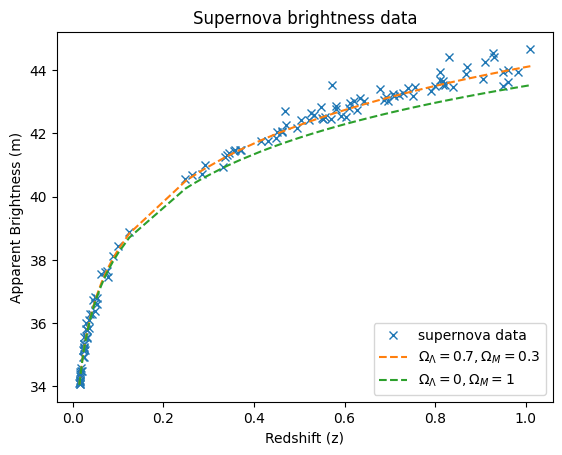

In [5]:
plt.plot(data['z'], data['mB'], marker = 'x', linestyle='', label='supernova data')
plt.plot(data['z'], brightness(data['z'], 0.7, 0.3), linestyle='--', label=r'$\Omega_{\Lambda}=0.7, \Omega_M=0.3$')
plt.plot(data['z'], brightness(data['z'], 0, 1), linestyle='--', label=r'$\Omega_{\Lambda}=0, \Omega_M=1$')
plt.xlabel('Redshift (z)')
plt.ylabel('Apparent Brightness (m)')
plt.title('Supernova brightness data')
plt.legend(loc='lower right')
plt.show()

In [6]:
df.sort_values('norm_like', inplace=True)
df['cdf'] = np.cumsum(df['norm_like'])
contour_max = df.iloc[(np.abs(df['cdf'] - 1)).argmin()]['norm_like']
contour68 = df.iloc[(np.abs(df['cdf'] - 0.32)).argmin()]['norm_like']
contour95 = df.iloc[(np.abs(df['cdf'] - 0.05)).argmin()]['norm_like']
contour99 = df.iloc[(np.abs(df['cdf'] - 0.01)).argmin()]['norm_like']
df.sort_index(inplace=True)
print(contour68, contour95)

0.00046190455779824733 0.00010270744178256079


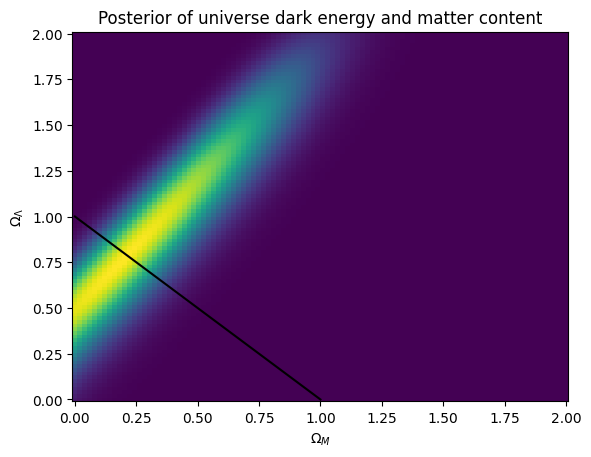

In [7]:
ax = plt.pcolormesh(mesh[0], mesh[1], df['norm_like'].values.reshape(n,n))
flat_universe = np.array([np.linspace(0,1), np.linspace(1,0)])

plt.plot(flat_universe[0], flat_universe[1], color='black')
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_{\Lambda}$')
plt.title('Posterior of universe dark energy and matter content')

plt.show()


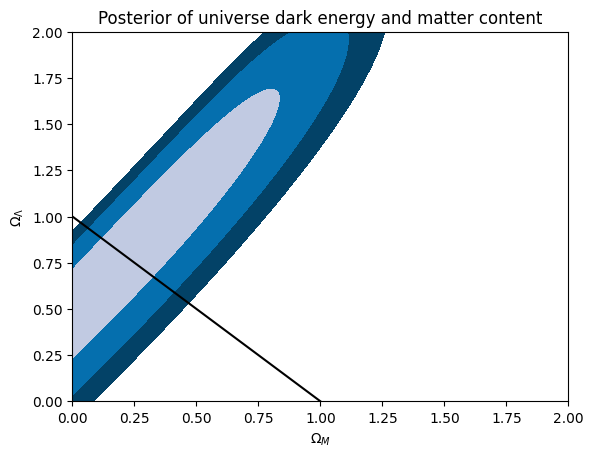

<Figure size 640x480 with 0 Axes>

In [8]:
ax = plt.contourf(mesh[0], mesh[1], df['norm_like'].values.reshape(n,n), levels=[contour99, contour95, contour68, contour_max], cmap=cm.PuBu_r)
# ax = plt.pcolormesh(mesh[0], mesh[1], df['norm_like'].values.reshape(n,n))
flat_universe = np.array([np.linspace(0,1), np.linspace(1,0)])

plt.plot(flat_universe[0], flat_universe[1], color='black')
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_{\Lambda}$')
plt.title('Posterior of universe dark energy and matter content')

plt.show()
plt.savefig('figs/cosmological_posterior.png')

The above graph shows the 2D posterior distribution over the parameters $\Omega_M$ and $\Omega_{\Lambda}$. It is cool to see how it is similar to the graph in the real scientific paper. We can now impose the additional prior belief that the universe is flat, which means that $\Omega_{\Lambda} + \Omega_M = 1$, shown by the black line. 

With this prior we can plot the posterior distribution along this line and find the most likely parameter values: $\Omega_{\Lambda} = 0.788,  \Omega_M = 0.222$. There are many further statistical tests that can be done to investigate the uncertainty distributions of these parameters, but we'll leave that up to you. 

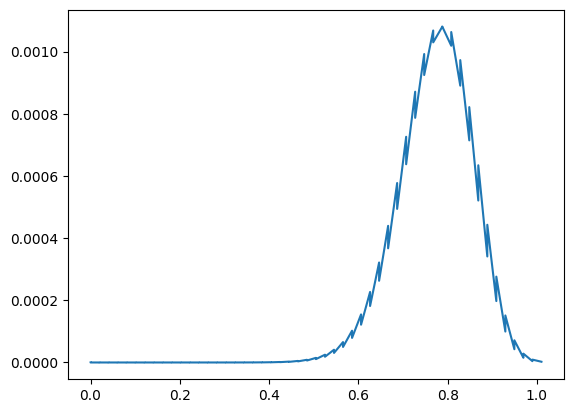

In [7]:
flat_like = df[abs(df['de']+ df['dm'] - 1) < 0.02]
plt.plot(flat_like['de'], flat_like['norm_like'])
plt.show()

In [8]:
flat_like[flat_like['norm_like'] == max(flat_like['norm_like'])]

,de,dm,loglike,like,norm_like,cdf
3911,0.787879,0.222222,-5.427825,0.004393,0.001081,0.993507
